# 0. Install required libraries

Uncomment the following cell and run it to install the required libraries. Make sure to start your virtual Python environment first (venv)

In [43]:
# %pip install -r requirements.txt

# 1. Setup
The first step is to import the necessary libraries and load the data and set the configuration.

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random


In [45]:
num_inputs = 3 # r, g, b
batch_size = 16
seed = 42
buffer_size = 1000
learning_rate = 0.1
epochs = 10
model_version = 'v0_2'
data_length = 1000 * 100

colors = [
    ('red', (255,0,0)),
    ('pink', (255,0,255)),
    ('purple', (156,39,176)),
    ('deepPurple', (103,58,183)),
    ('indigo', (63,81,181)),
    ('blue', (0,0,255)),
    ('lightBlue', (3,169,244)),
    ('cyan', (0,255,255)),
    ('teal', (0,150,136)),
    ('green', (0,255,0)),
    ('lightGreen', (139,195,74)),
    ('lime', (205,220,57)),
    ('yellow', (255,255,0)),
    ('amber', (255,191,0)),
    ('orange', (255,128,0)),
    ('deepOrange', (255,87,34)),
    ('brown', (121,85,72)),
    ('blueGrey', (96,125,139)),
    ('grey', (158,158,158)),
    ('black', (0,0,0)),
    ('white', (255,255,255)),
]
num_outputs = len(colors)


- v0_1: Initial version
- v0_2: changed to softmax for better output

### 1.1. Create dataset using labels

In [46]:
train_data = []
train_labels = []
test_data = []
test_labels = []
for i in range(int(data_length * 0.9)):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    x = [r, g, b]
    label = colors.index(min(colors, key=lambda c: sum((c[1][i] - x[i])**2 for i in range(num_inputs))))
    label = tf.one_hot(label, num_outputs)
    x = [c / 255 for c in x]
    if i % 8 == 0:
        test_data.append(x)
        test_labels.append(label)
    else:
        train_data.append(x)
        train_labels.append(label)

for i in range(int(data_length * 0.1)):
    # ('yellow', (255,255,0)),
    # ('amber', (255,191,0)),
    # ('orange', (255,128,0)),
    r = random.randint(240, 255)
    g = random.randint(128, 255)
    b = random.randint(0, 10)
    x = [r, g, b]
    label = colors.index(min(colors, key=lambda c: sum((c[1][i] - x[i])**2 for i in range(num_inputs))))
    label = tf.one_hot(label, num_outputs)
    x = [c / 255 for c in x]
    if i % 8 == 0:
        test_data.append(x)
        test_labels.append(label)
    else:
        train_data.append(x)
        train_labels.append(label)
    # pass

train_colors = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_colors = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

print(f'Got {len(train_data)} training samples and {len(test_data)} test samples' )

Got 87500 training samples and 12500 test samples


In [47]:
print('Distribution of colors in training data:')
color_counts = [0] * num_outputs
for color_encoded in train_labels:
    color_index = tf.argmax(color_encoded)
    color_counts[color_index] += 1

for i, color in enumerate(colors):
    print(f'{color[0]}: {color_counts[i]} ({color_counts[i] / len(train_data) * 100:.2f}%)')


Distribution of colors in training data:
red: 1168 (1.33%)
pink: 1559 (1.78%)
purple: 6892 (7.88%)
deepPurple: 3897 (4.45%)
indigo: 5169 (5.91%)
blue: 1012 (1.16%)
lightBlue: 2833 (3.24%)
cyan: 1629 (1.86%)
teal: 5184 (5.92%)
green: 2265 (2.59%)
lightGreen: 7695 (8.79%)
lime: 4469 (5.11%)
yellow: 2436 (2.78%)
amber: 4917 (5.62%)
orange: 3143 (3.59%)
deepOrange: 3615 (4.13%)
brown: 9898 (11.31%)
blueGrey: 3786 (4.33%)
grey: 11225 (12.83%)
black: 2313 (2.64%)
white: 2395 (2.74%)


In [48]:
train_length = len(train_data)
steps_per_epoch = train_length // batch_size


In [49]:
train_batches = (
    train_colors
    .cache()
    .shuffle(buffer_size, seed=seed)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_colors.batch(batch_size)


### 1.2. Validate data and labels are loaded correctly

In [50]:
def display(input, label, prediction=None):
    input = [int(c * 255) for c in input]
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.imshow([[input]], interpolation='nearest')
    label_index = tf.argmax(label, axis=-1).numpy()
    plt.title(f'{colors[label_index][0]}')
    plt.axis('off')
    
    if prediction is not None:
        plt.subplot(1, 2, 2)
        labels = range(len(colors))
        bar_colors = [f'#{r:02x}{g:02x}{b:02x}' for name, (r, g, b) in colors]
        bar_names = [name for name, _ in colors]
        plt.bar(labels, prediction[0], color=bar_colors)
        plt.xticks(labels, bar_names, rotation=45, ha='right')
        plt.title("Prediction")
        plt.tight_layout()
    plt.show()


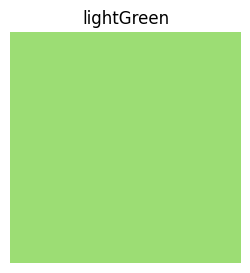

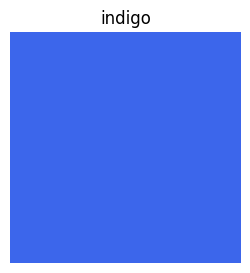

In [51]:
for input, label in train_colors.take(2):
  sample_color, sample_label = input, label
  display(input, label)

# 2. Create a model

In [52]:
def create_classification_model(input_shape=(num_inputs,)):
    input_layer = layers.Input(shape=input_shape)
    output_layer = layers.Dense(num_outputs, activation='softmax')(input_layer)
    model = models.Model(inputs=input_layer, outputs=[output_layer])
    return model


### 2.1. Compile the model

In [53]:

model = create_classification_model()

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(),
              metrics='mse')

# model.summary()

### 2.2. Check predictions are working correctly

In [54]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, bboxes in dataset.take(num):
            predictions = model.predict(image)  # Predict bounding boxes
            display(image, bboxes, predictions)  # Visualize image with predicted bboxes
    else:
        predictions = model.predict(sample_color[tf.newaxis, ...])  # Predict bounding boxes on a sample image
        display(sample_color, sample_label, predictions)  # Visualize sample image with predicted bboxes


1/1 [==============================] - 0s 42ms/step


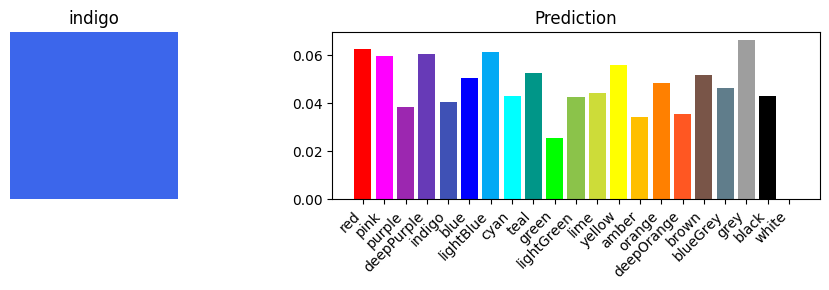

In [55]:
show_predictions()


In [56]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


# 3. Train the model

1/1 [==============================] - 0s 17ms/step


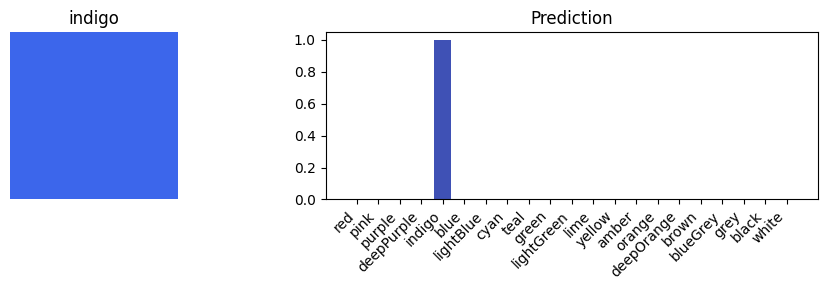


Sample Prediction after epoch 10

5468/5468 [==============================] - 5s 917us/step - loss: 0.1547 - mse: 0.0039


In [57]:
validation_subsplits = 3
validation_steps = train_length//batch_size//validation_subsplits

model_history = model.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


# 4. Evaluate history (check for overfitting etc)

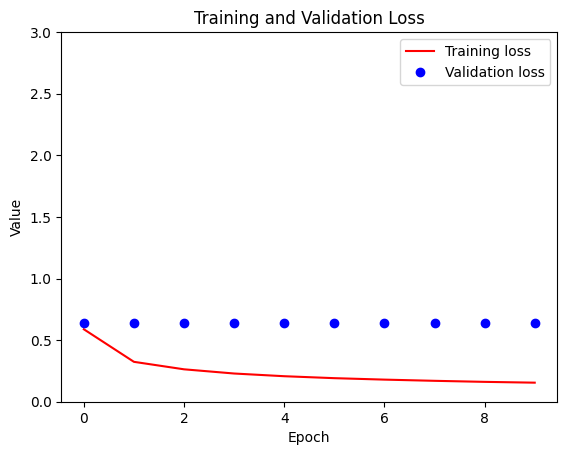

In [58]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

if len(val_loss) < len(loss):
    val_loss += [val_loss[-1]] * (len(loss) - len(val_loss))

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim([0, 3])
plt.legend()
plt.show()


# 5. Manually evaluate the model on the test set

1/1 [==============================] - 0s 20ms/step


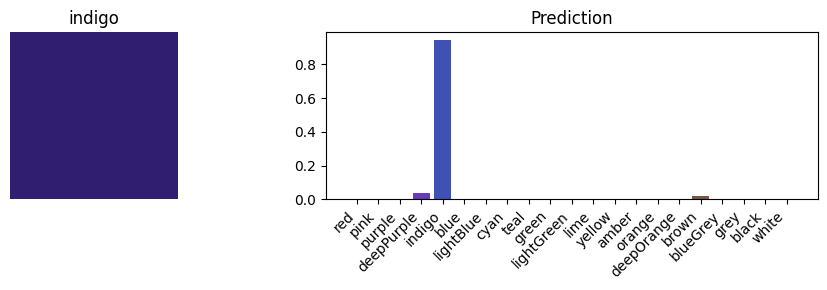

1/1 [==============================] - 0s 17ms/step


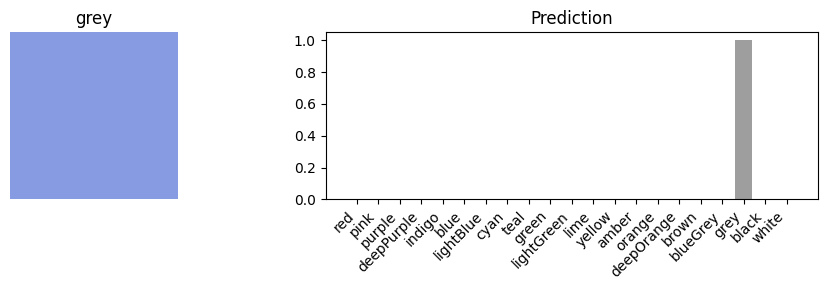

1/1 [==============================] - 0s 18ms/step


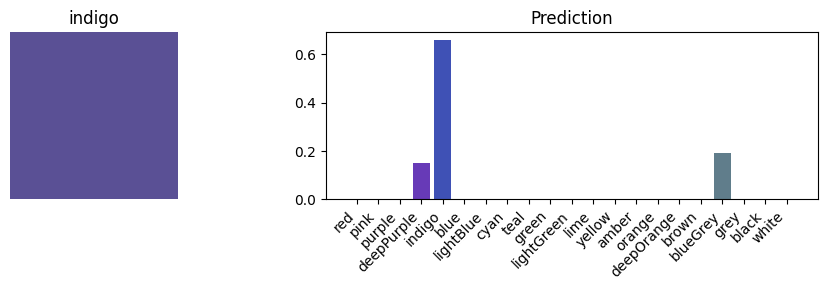

1/1 [==============================] - 0s 18ms/step


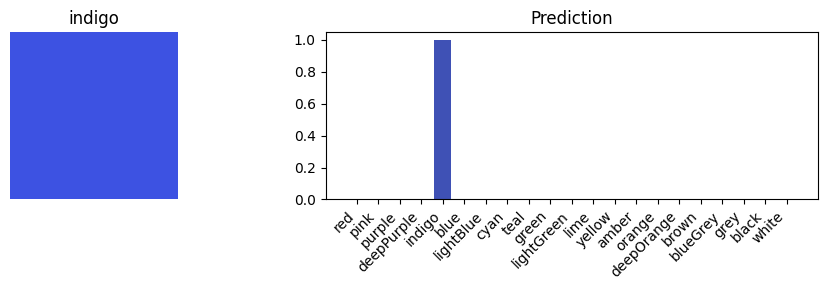

1/1 [==============================] - 0s 19ms/step


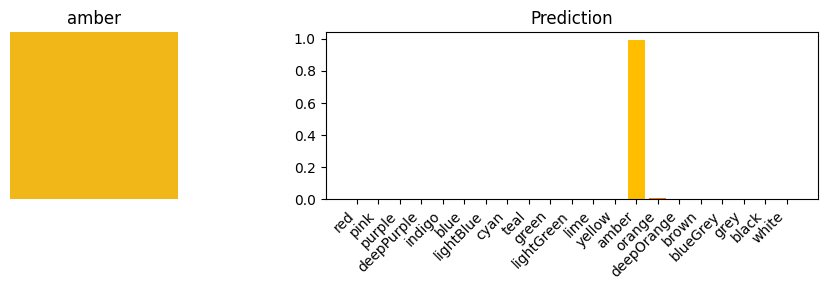

In [59]:
for input, label in test_colors.take(5):
  sample_color, sample_label = input, label
  show_predictions()

# 6. Save the model

In [60]:
model.save(f'models/{model_version}.keras')


In [61]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(f'models/{model_version}.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmprn7h2i6u/assets


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmprn7h2i6u/assets
2024-11-01 12:46:14.068044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-01 12:46:14.068067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-01 12:46:14.068266: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmprn7h2i6u
2024-11-01 12:46:14.068989: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-01 12:46:14.069001: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmprn7h2i6u
2024-11-01 12:46:14.071181: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-11-01 12:46:14.107413: I tensorflow/cc/saved_model/loader.cc:217] Running initialization